In [ ]:
   from google.colab import drive
   drive.mount('/content/drive')

Mounted at /content/drive




---

**Q1**

**Using ViT Model**

In [ ]:
!pip install transformers torchvision ftfy scipy
from transformers import CLIPProcessor, CLIPModel
import torch

# Loading the model and processor from Huggingface
model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

**CLIP Model Description**

Architecture: Vision Transformer (ViT-L/14):

1. The vision encoder divides the image into 14x14 patches and encodes them into vectors.
2. 24 transformer layers process these patch embeddings.
3. Uses multi-head self-attention (MHSA) and feedforward neural networks for feature extraction.

Parameters:

Patch Embedding:

* Each patch is linearly embedded into a vector of size 1024.


Multi-Head Attention (MHSA):

* Computes attention using Q,K,V matrices.
* Each attention head operates independently before aggregating the results.


Feedforward Layers:

* Each transformer layer includes two dense layers for feature transformation.

Final Projection:
* Maps vision and text embeddings into a shared embedding space.


Number of Parameters:
* The model has ~428 million parameters in total.

These parameters are distributed across:

1. Patch embeddings: Linear layers for encoding patches.
2. Transformer layers: Attention and feedforward weights.
3. Projection layer: Dense layers aligning image and text embeddings.



---
**Q2**

**Evaluating the model**

In [ ]:
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

class ModelvsBabyDataset(Dataset):
    def __init__(self, root_dir, categories, processor):
        self.root_dir = root_dir
        self.categories = categories
        self.processor = processor
        self.data = []

        for condition in os.listdir(root_dir):
            condition_path = os.path.join(root_dir, condition)
            for category in categories:
                category_path = os.path.join(condition_path, category)
                for img_file in os.listdir(category_path):
                    self.data.append((os.path.join(category_path, img_file), condition, category))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, condition, category = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), condition, category,img_path

# Initializing the dataset
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
root_dir = "/content/drive/MyDrive/AI_ML_4/image_files/v0"
dataset = ModelvsBabyDataset(root_dir, categories, processor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [ ]:
import torch.nn.functional as F

# Preparing category text embeddings
text_inputs = processor.tokenizer(categories, padding=True, return_tensors="pt")
text_features = model.get_text_features(**text_inputs)

accuracy_per_condition = {condition: {"correct": 0, "total": 0} for condition in os.listdir(root_dir)}

model.eval()
for image, condition, true_category in dataloader:
    with torch.no_grad():
        image_features = model.get_image_features(image)
        similarities = F.cosine_similarity(image_features, text_features)
        predicted_category = categories[similarities.argmax().item()]

        condition_str = condition[0]
        accuracy_per_condition[condition_str]["total"] += 1
        if predicted_category == true_category[0]:
            accuracy_per_condition[condition_str]["correct"] += 1

# Calculating accuracy
for condition, stats in accuracy_per_condition.items():
    accuracy = stats["correct"] / stats["total"]
    print(f"{condition}, Accuracy: {accuracy * 100:.2f}%")


blurred, Accuracy: 85.71%
silhouettes, Accuracy: 92.50%
realistic, Accuracy: 100.00%
geons, Accuracy: 55.93%
features, Accuracy: 90.48%




---


* Evaluated the model on all five conditions (realistic, geons, silhouettes, blurred, and features) using cosine similarity for label prediction.
* Model Accuracy was quantified for each condition.

In [ ]:
# Example comparison with baby data as per Fig. 3A as specified
baby_performance = {
    "realistic": 0.85,
    "geons": 0.58,
    "silhouettes": 0.78,
    "blurred": 0.56,
    "features": 0.54,
}

for condition in accuracy_per_condition:
    model_acc = accuracy_per_condition[condition]["correct"] / accuracy_per_condition[condition]["total"]
    baby_acc = baby_performance[condition]
    print(f"Condition: {condition}")
    print(f"  Model Accuracy: {model_acc:.2f}")
    print(f"  Baby Accuracy: {baby_acc:.2f}")
    print(f"  Difference: {model_acc - baby_acc:.2f}")


Condition: blurred
  Model Accuracy: 0.86
  Baby Accuracy: 0.56
  Difference: 0.30
Condition: silhouettes
  Model Accuracy: 0.93
  Baby Accuracy: 0.78
  Difference: 0.15
Condition: realistic
  Model Accuracy: 1.00
  Baby Accuracy: 0.85
  Difference: 0.15
Condition: geons
  Model Accuracy: 0.56
  Baby Accuracy: 0.58
  Difference: -0.02
Condition: features
  Model Accuracy: 0.90
  Baby Accuracy: 0.54
  Difference: 0.36


The model was able to classify better in Features condition. It performed a bit lower when the condition was geons



---

**Q3**

**t-SNE Visualization**

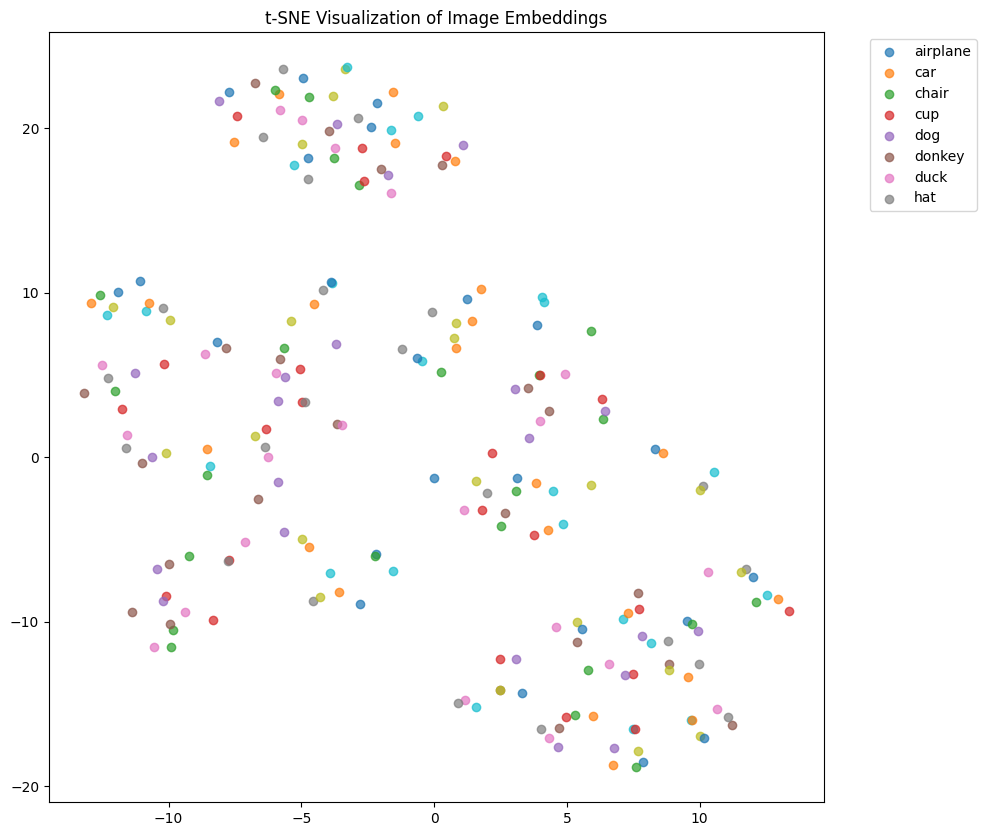

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Extract embeddings
embeddings = []
labels = []
image_paths_tracked=[]
model.eval()
for image, _, label, img_path in dataloader:
    with torch.no_grad():
        image_features = model.get_image_features(image).cpu().numpy()
        embeddings.append(image_features.squeeze(0))
        labels.append(label)
        image_paths_tracked.append(img_path)

embeddings = np.array(embeddings)

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plotting t-SNE
plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, label=label, alpha=0.7)

plt.legend(categories, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Visualization of Image Embeddings")
plt.show()


In [ ]:
print(len(reduced_embeddings))
print(len(image_paths_tracked))


224
224


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_with_images(tsne_results, image_paths_tracked, zoom=0.4):
    fig, ax = plt.subplots(figsize=(15, 10))

    for i, (x, y) in enumerate(tsne_results):
        img_path=image_paths_tracked[i][0]
        img = Image.open(img_path)
        img = img.resize((30, 30))
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    ax.set_xlim(tsne_results[:, 0].min() - 5, tsne_results[:, 0].max() + 5)
    ax.set_ylim(tsne_results[:, 1].min() - 5, tsne_results[:, 1].max() + 5)
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.axis('off')
    plt.show()

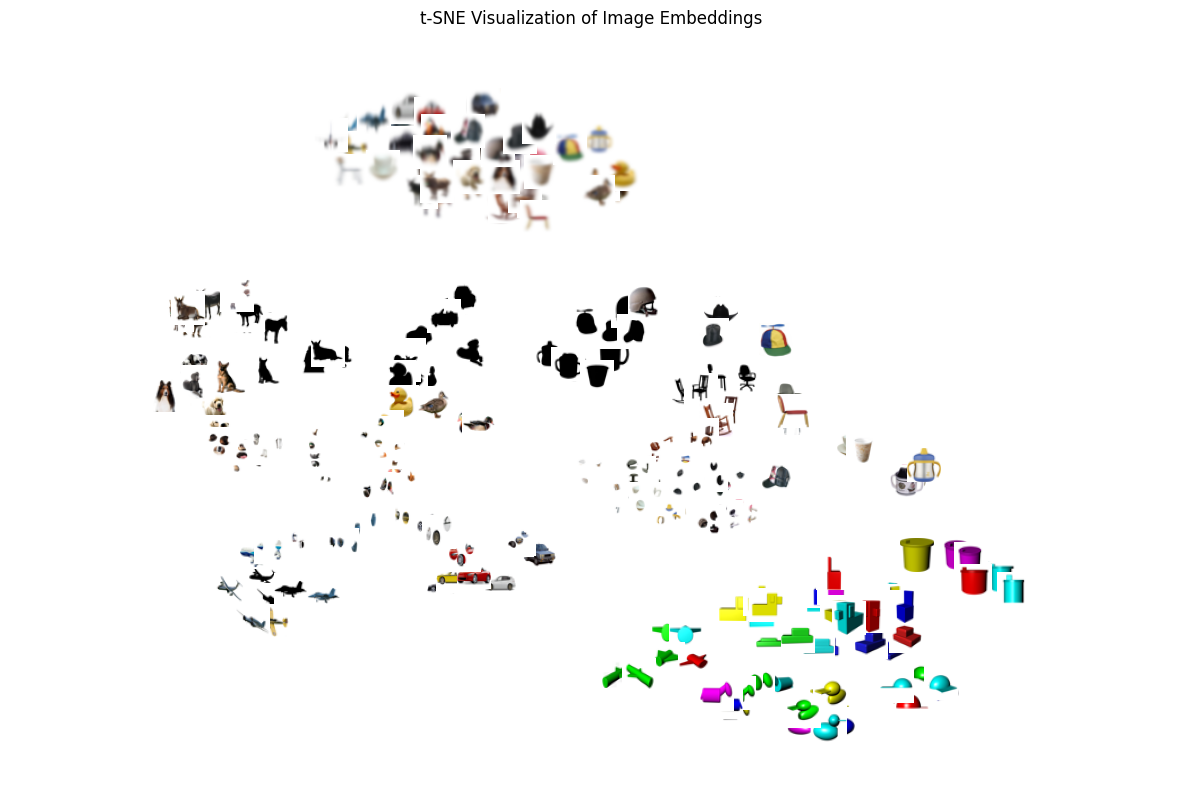

In [ ]:
plot_with_images(reduced_embeddings, image_paths_tracked, zoom=0.8)